
#### Time Series

A time series is a sequential set of data points, measured typically over successive times.
It is mathematically defined as a set of vectors x(t), t = 0,1,2,... where t represents the time elapsed.
The variable x(t) is treated as a random variable.
The measurements taken during an event in a time series are arranged in a proper chronological order.

A time series containing records of a single variable is termed as univariate, and more than one variable a multivariate.

#### Business use cases of time series forecasting

● Sales forecast - retail products sales forecast

● Demand forecasting - used in pricing, inventory and workforce management

● Traffic forecast - transport and route optimization, road facility design

● Revenue forecast - budgeting, target setting

● Stock market forecast - price of the stocks

In [124]:
#setting working directory
getwd()
setwd("D:/Folders/R/Time Series")

[1] "D:/Folders/R/Time Series"

In [125]:
#installing and importing libraries
library(tseries)
library(dplyr)
library(ggplot2)
library(corrplot)
library(forecast)
library(zoo)
library(roll)
library(urca)
library(xts)
library(rlang)
library(Metrics)


#### DATA IMPORT AND CLEANING

● importing data - taken from https://www.kaggle.com/andreazzini/international-airline-passengers/data

● fileencoding allows to read the characters as correctly as they would appear on the raw dataset

● na.strings allows to replace blanks with NAs


In [126]:
IntlAirPassengers4 <- read.csv("D:/Folders/R/Time Series/international-airline-passengers.csv",fileEncoding="UTF-8-BOM",na.strings = '..', stringsAsFactors =FALSE)


In [127]:
#data cleaning
IntlAirPassengers3 <- IntlAirPassengers4 %>%  rename(monthly_passengers = International.airline.passengers..monthly.totals.in.thousands..Jan.49...Dec.60,
                                                     month_old = Month) 

IntlAirPassengers2 <- IntlAirPassengers3[-c(145),]

#converting to datetime
IntlAirPassengers2$Month <- as.Date(paste(IntlAirPassengers2$month_old,"-01",sep=""))

#removing unwanted rows
IntlAirPassengers <- IntlAirPassengers2[,-c(1)]
head(IntlAirPassengers)

monthly_passengers,Month
112,1949-01-01
118,1949-02-01
132,1949-03-01
129,1949-04-01
121,1949-05-01
135,1949-06-01


In [128]:

# CHECKING THE DATA – MEASURES OF CENTRAL TENDENCY AND DATA TYPES
### list objects in the working environment
ls(IntlAirPassengers)

### list the structure of IntlAirPassengers
str(IntlAirPassengers)

### dimensions of an object
dim(IntlAirPassengers)

### class of an object (numeric, matrix, data frame, etc)
class(IntlAirPassengers)

### print first 10 rows of mydata
head(IntlAirPassengers, n=10)
summary(IntlAirPassengers)

#printing max and min time period
strtdt <- min(IntlAirPassengers$Month)
enddt <- max(IntlAirPassengers$Month)
cat("\nTime period start: ", as.character(strtdt))
cat("\nTime period end: ", as.character(enddt))


[1] "Month"              "monthly_passengers"

'data.frame':	144 obs. of  2 variables:
 $ monthly_passengers: int  112 118 132 129 121 135 148 148 136 119 ...
 $ Month             : Date, format: "1949-01-01" "1949-02-01" ...


[1] 144   2

[1] "data.frame"

monthly_passengers,Month
112,1949-01-01
118,1949-02-01
132,1949-03-01
129,1949-04-01
121,1949-05-01
135,1949-06-01
148,1949-07-01
148,1949-08-01
136,1949-09-01
119,1949-10-01


 monthly_passengers     Month           
 Min.   :104.0      Min.   :1949-01-01  
 1st Qu.:180.0      1st Qu.:1951-12-24  
 Median :265.5      Median :1954-12-16  
 Mean   :280.3      Mean   :1954-12-16  
 3rd Qu.:360.5      3rd Qu.:1957-12-08  
 Max.   :622.0      Max.   :1960-12-01  


Time period start:  1949-01-01
Time period end:  1960-12-01

#### DATA VISUALIZATION FOR INSPECTION
    
● in case there are multiple columns, we may need to combine them to see a boxplot


Warning message:
"Use of `IntlAirPassengers$monthly_passenger` is discouraged. Use `monthly_passenger` instead."Warning message:
"Use of `IntlAirPassengers$monthly_passenger` is discouraged. Use `monthly_passenger` instead."

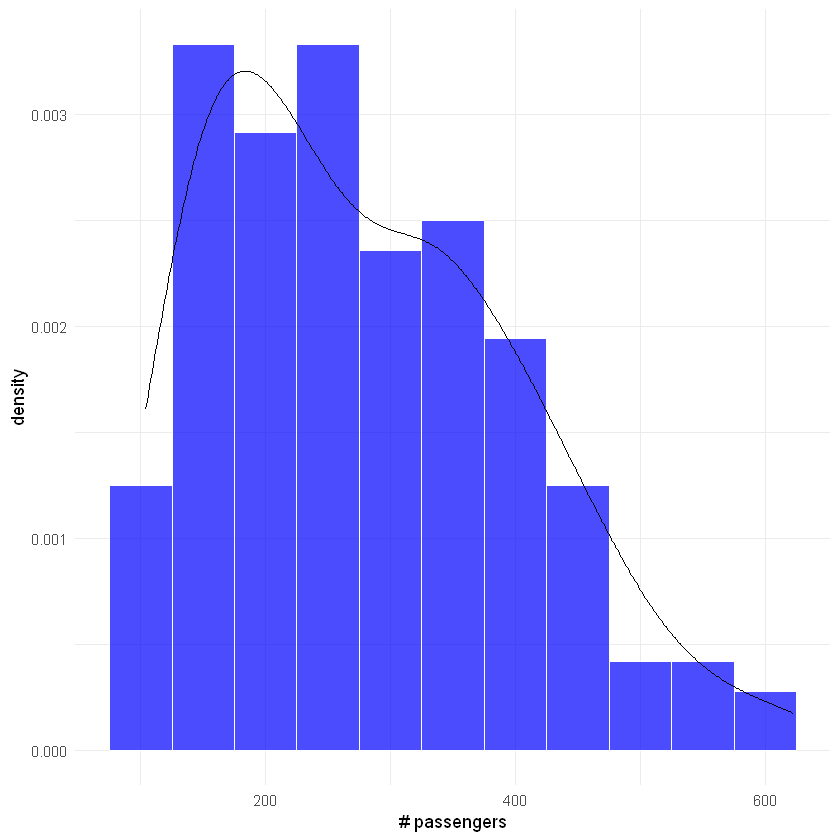

In [129]:

#barplot
ggplot(data = IntlAirPassengers, mapping = aes(x=IntlAirPassengers$monthly_passenger)) + 
  geom_histogram(aes(y=..density..),fill="blue",color="white",alpha=0.7,binwidth=50) + 
  geom_density() +
  labs(x='# passengers') +
  theme_minimal()

### Boxplot by years
Median values across years confirms an upwards trend
    
Steady increase in the spread, or middle 50% of the data (boxes) over time

A model considering seasonality might work well

### Boxplot across the months will give us a sense of the seasonal effects

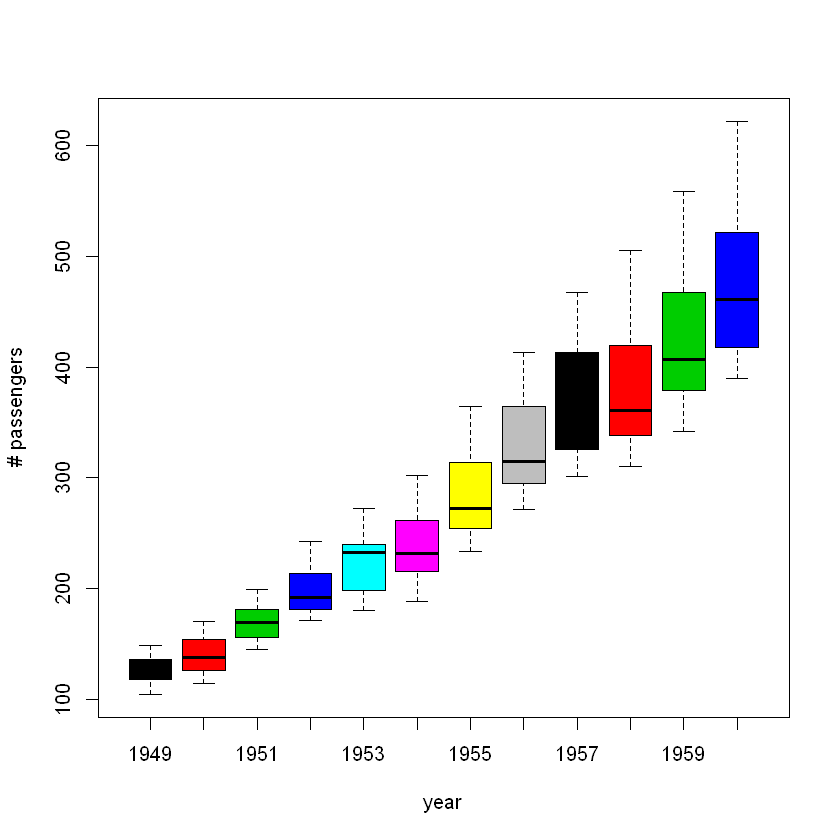

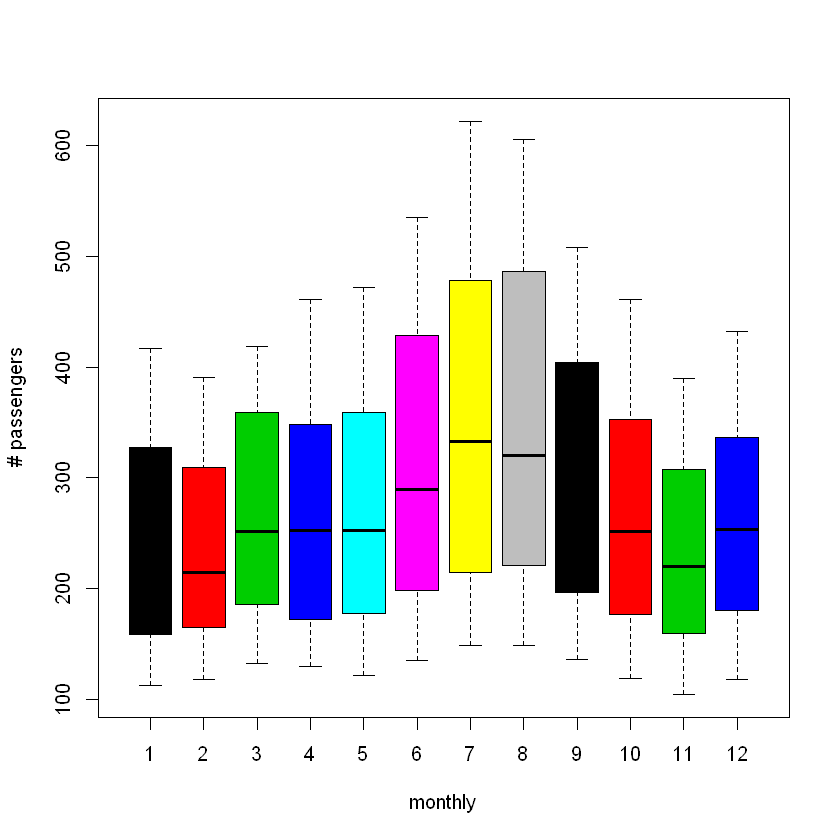

In [130]:
year <- as.numeric(format(IntlAirPassengers$Month,'%Y'))
boxplot(IntlAirPassengers$monthly_passengers~year, col=c(1:12), ylab = "# passengers")

monthly <- as.numeric(format(IntlAirPassengers$Month,'%m'))
boxplot(IntlAirPassengers$monthly_passengers~monthly, col=monthly, ylab = "# passengers")

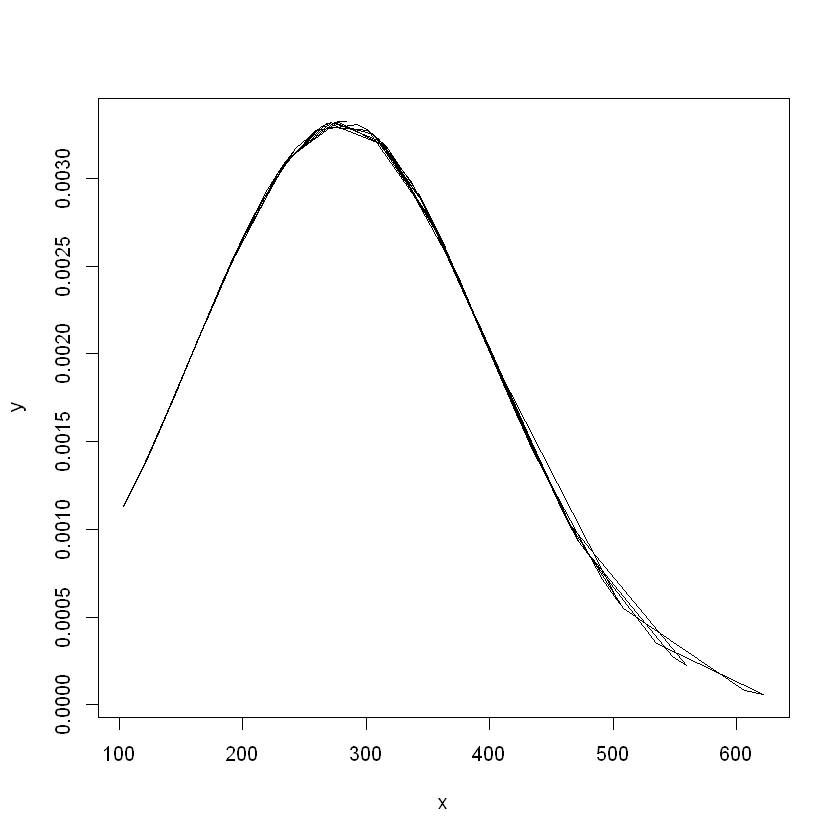

In [131]:
# checking normal distribution. data is right skewed, not perfectly Gaussian (normal), transformations might be helpful
x <- IntlAirPassengers$monthly_passengers
y <- dnorm(IntlAirPassengers$monthly_passengers, mean = mean(IntlAirPassengers$monthly_passengers), sd = sd(IntlAirPassengers$monthly_passengers))
plot(x,y, type = "l")


In [132]:
# CHECKING THE DATA FREQUENCY
frequency(IntlAirPassengers$monthly_passengers)


[1] 1

#### DECOMPOSING THE DATA TO CHECK THE TREND, SEASONALITY AND RANDOM NOISE

● Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.

● Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.

● Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

● Additive decomposition = Seasonal + Trend + Random

● Multiplicative decomposition = Seasonal * Trend * Random


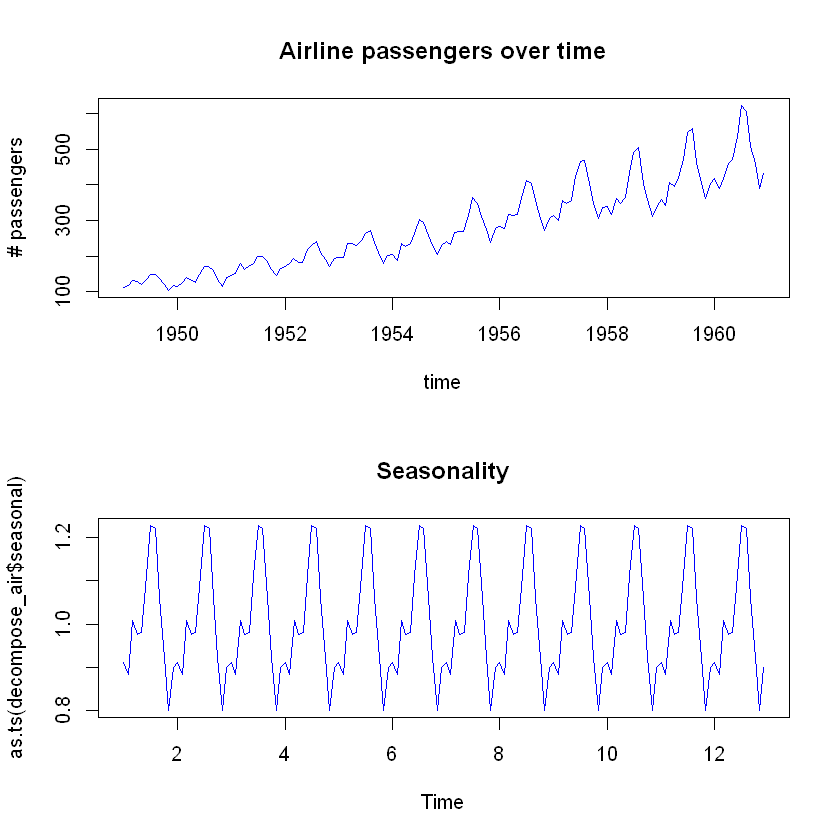

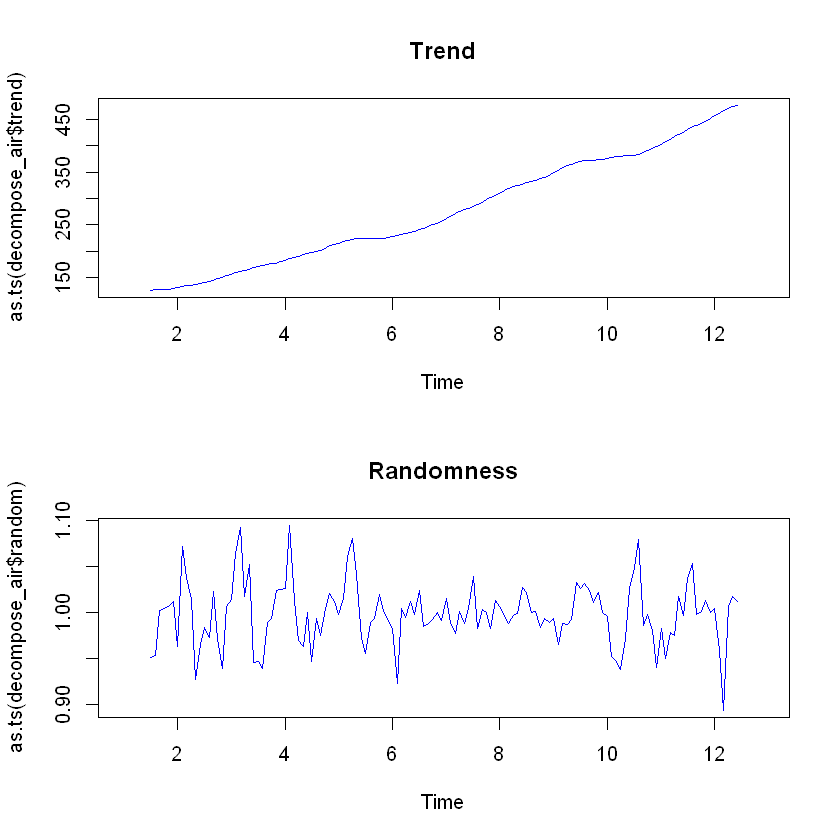

In [133]:
# TO DETECT TREND

ts_air <- ts(IntlAirPassengers$monthly_passengers, frequency = 12)
decompose_air <- decompose(ts_air, "multiplicative")
par(mfrow=c(2,1))
# Line graph
plot(IntlAirPassengers$Month,IntlAirPassengers$monthly_passengers, type="l", col="blue", xlab = "time", ylab = "# passengers", main = "Airline passengers over time")
plot(as.ts(decompose_air$seasonal), main = "Seasonality", type="l", col="blue")
plot(as.ts(decompose_air$trend), main = "Trend", type="l", col="blue")
plot(as.ts(decompose_air$random), main = "Randomness", type="l", col="blue")
par(mfrow=c(1,1))

### Stationarity
● A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
    
● Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.

● Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

● Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.


### We can check stationarity using the following:
  
● ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

● Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

● Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 

● If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.


###  ACF and PACF plots

● Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

● If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

● This data is non-stationary as a high number of previous observations are correlated with future values.

● Confidence intervals are drawn as a cone.
By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

● The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.


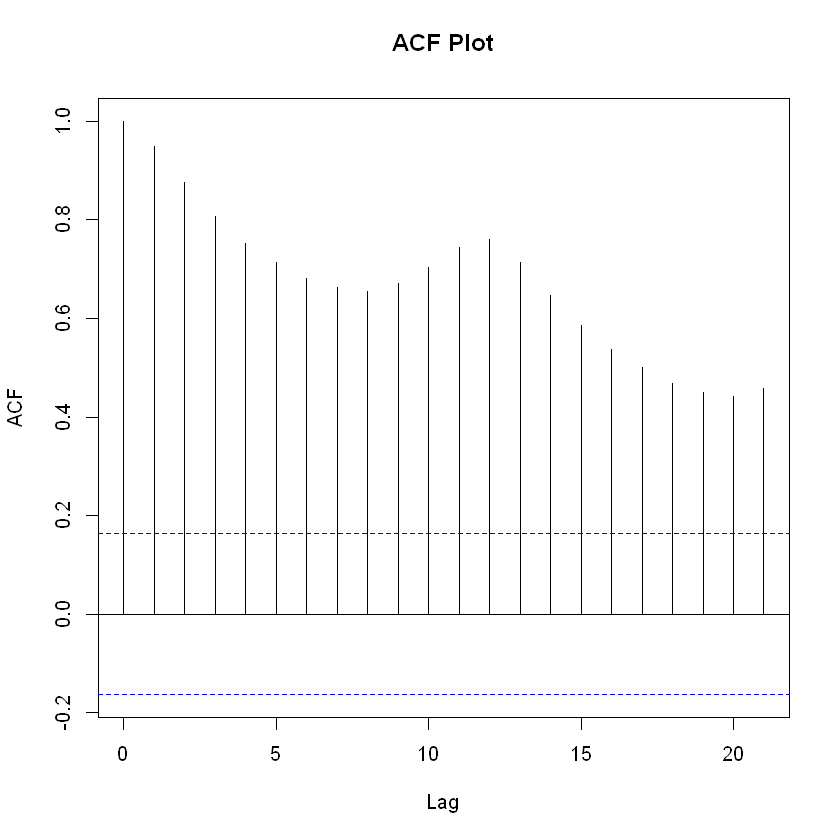

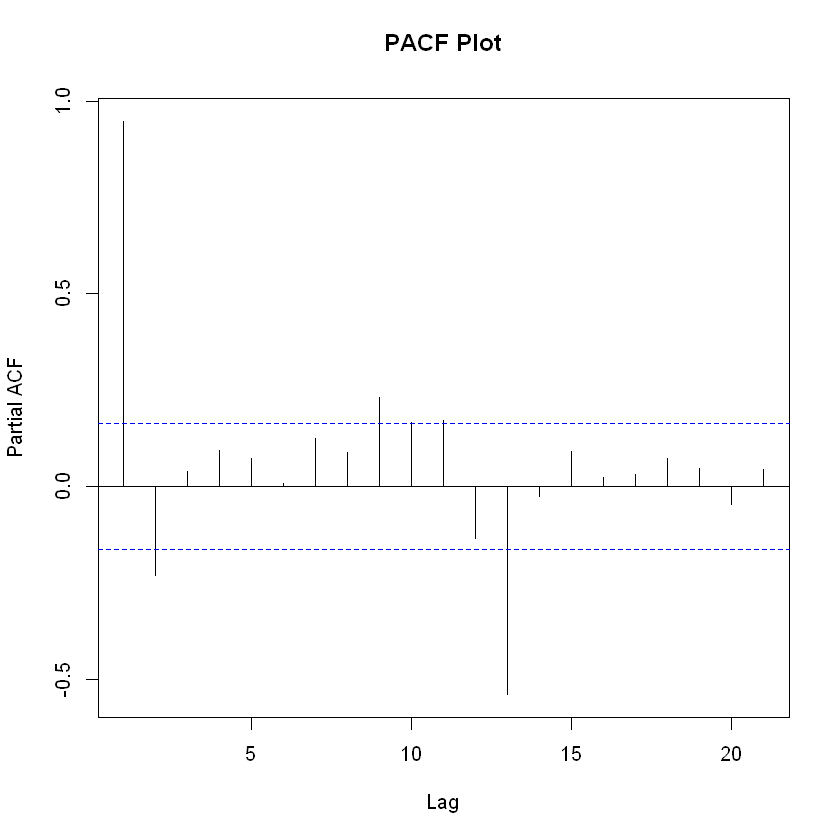

In [134]:
acf(IntlAirPassengers$monthly_passengers, main = "ACF Plot")
pacf(IntlAirPassengers$monthly_passengers, main = "PACF Plot")

Clearly, the decay of ACF chart is very slow, which means that the population is not stationary.

Plotting Rolling Statistics

● We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)

● The time series is hence not stationary

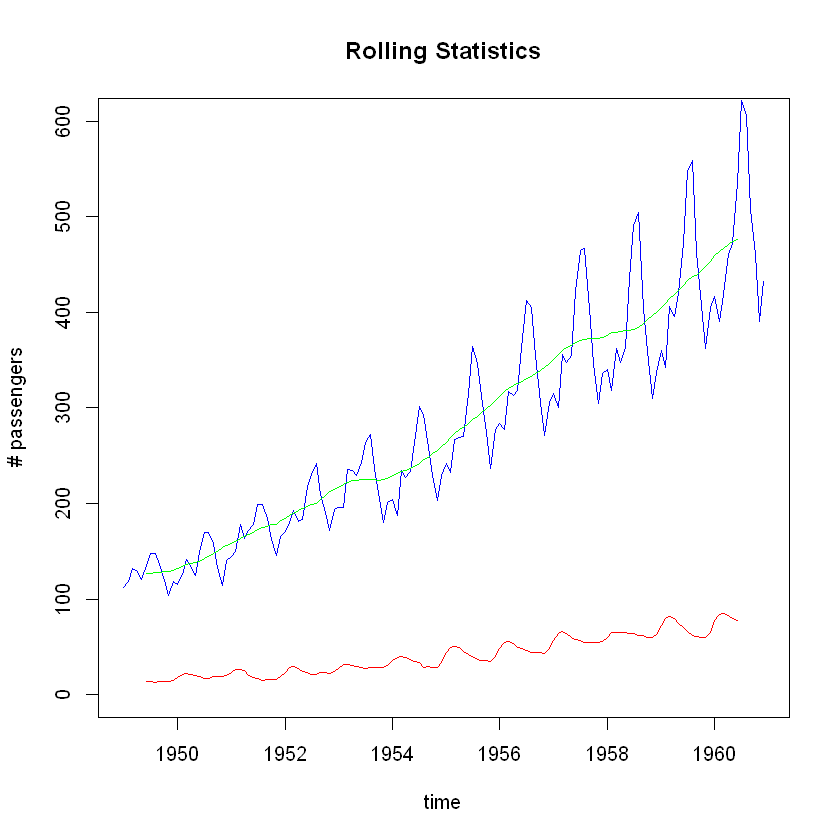

In [135]:
rolling_mean <- rollmean(IntlAirPassengers$monthly_passengers, k = 12, fill = NA)
rolling_sd <- rollapply(IntlAirPassengers$monthly_passengers, width = 12, FUN = sd, fill = NA)

plot(IntlAirPassengers$Month,IntlAirPassengers$monthly_passengers, type="l", col="blue", xlab = "time", ylab = "# passengers", main = "Rolling Statistics",ylim=c(0,600)) 
lines(IntlAirPassengers$Month,rolling_mean, type="l", col="green") 
lines(IntlAirPassengers$Month,rolling_sd, type="l", col="red") 

### Augmented Dickey-Fuller Test

The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

Null hypothesis: The time series is not stationary

Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity


In [136]:
adf.test(IntlAirPassengers$monthly_passengers, alternative = "stationary", k=12)


	Augmented Dickey-Fuller Test

data:  IntlAirPassengers$monthly_passengers
Dickey-Fuller = -1.5094, Lag order = 12, p-value = 0.7807
alternative hypothesis: stationary


### KPSS Test 
    
    Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.


In [137]:
tseries::kpss.test(IntlAirPassengers$monthly_passengers, null = "Trend", lshort = TRUE) #p-value<0.1 indicates H0 is not rejected

Warning message in tseries::kpss.test(IntlAirPassengers$monthly_passengers, null = "Trend", :
"p-value greater than printed p-value"


	KPSS Test for Trend Stationarity

data:  IntlAirPassengers$monthly_passengers
KPSS Trend = 0.09615, Truncation lag parameter = 4, p-value = 0.1


Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:
  
● Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
● Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.


### Transformations
We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:


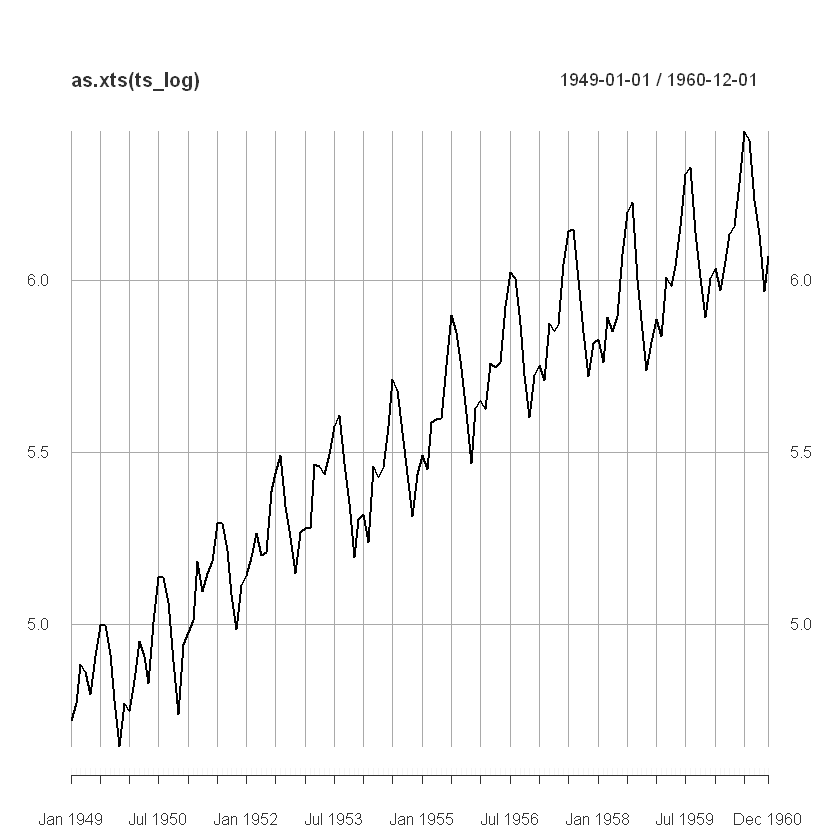

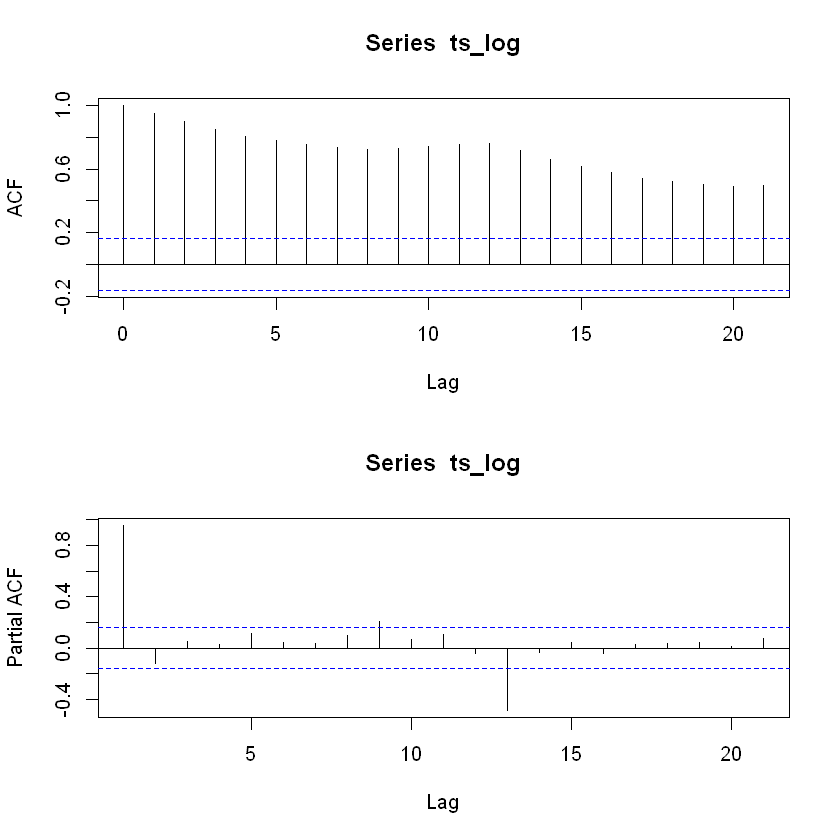

In [138]:

tslog <- IntlAirPassengers
tslog$monthly_passengers <- log(IntlAirPassengers$monthly_passengers)
ts_log <- xts(tslog$monthly_passengers, order.by = tslog$Month)

plot(as.xts(ts_log)) 

# ACF and PACF Plots
par(mfrow=c(2,1))
acf(ts_log)
pacf(ts_log)
par(mfrow=c(1,1))

### Other possible transformations:
    
● Exponential tranformation

● Box Cox transformation

● Square root transformation

### Techniques to remove Trend - Smoothing

● Smoothing is taking rolling averages over windows of time

● Moving Average
We take average of ‘k’ consecutive values depending on the frequency of time series.
Here we can take the average over the past 1 year, i.e. last 12 values.

A drawback in this particular approach is that the time-period has to be strictly defined.


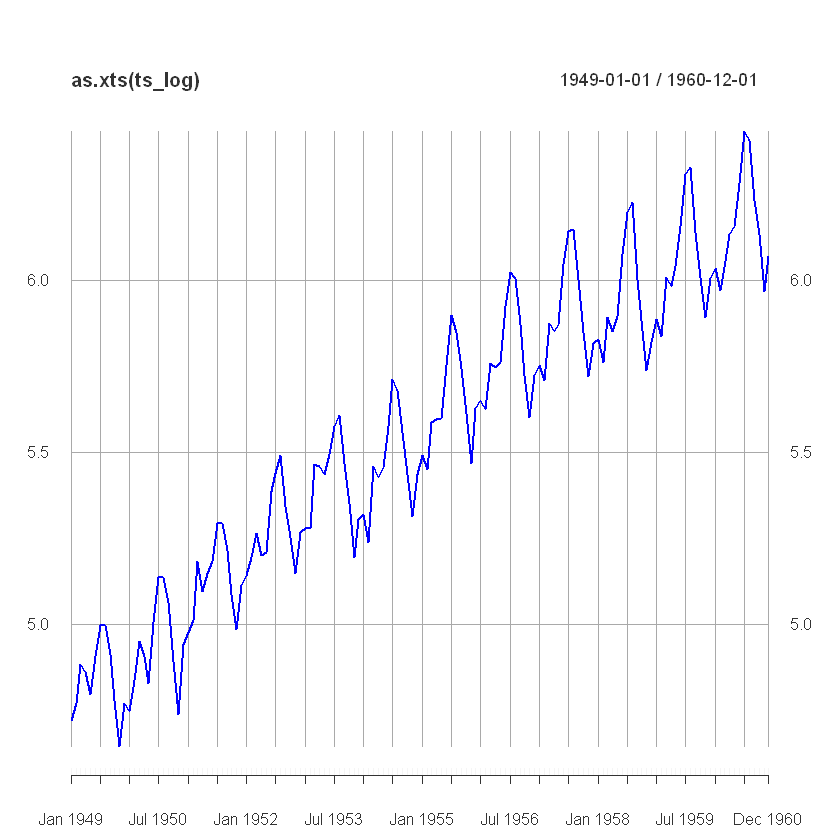

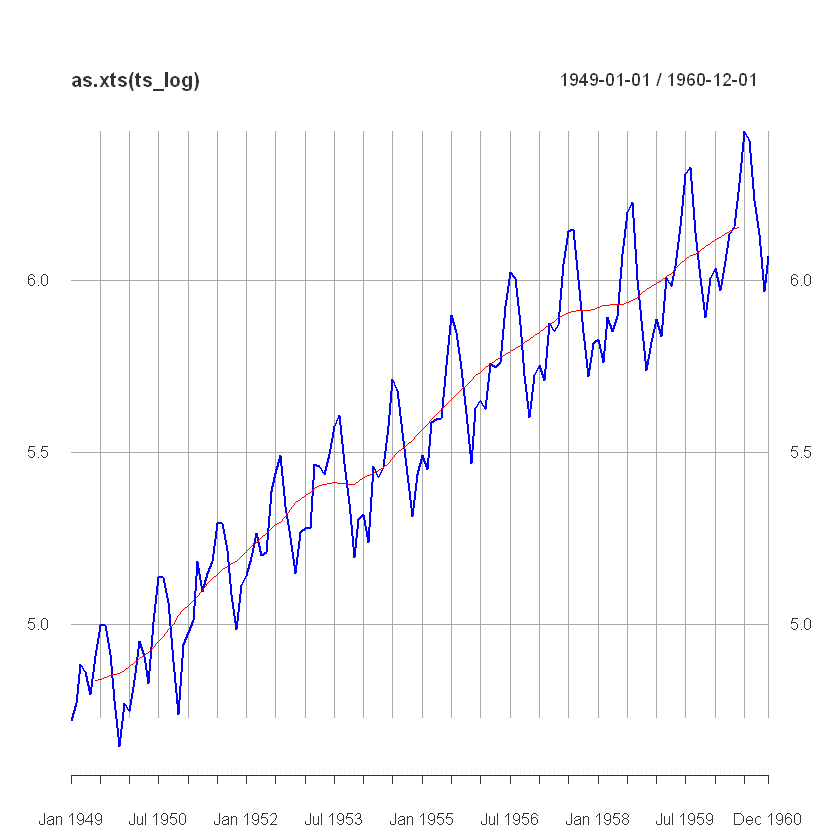

In [139]:
moving_avg <- rollmean(ts_log, k = 12,fill = NA)
plot(as.xts(ts_log), type="l", col="blue", xlab = "time", ylab = "# passengers(log transform)") 
lines(as.xts(moving_avg), type="l", col="red")


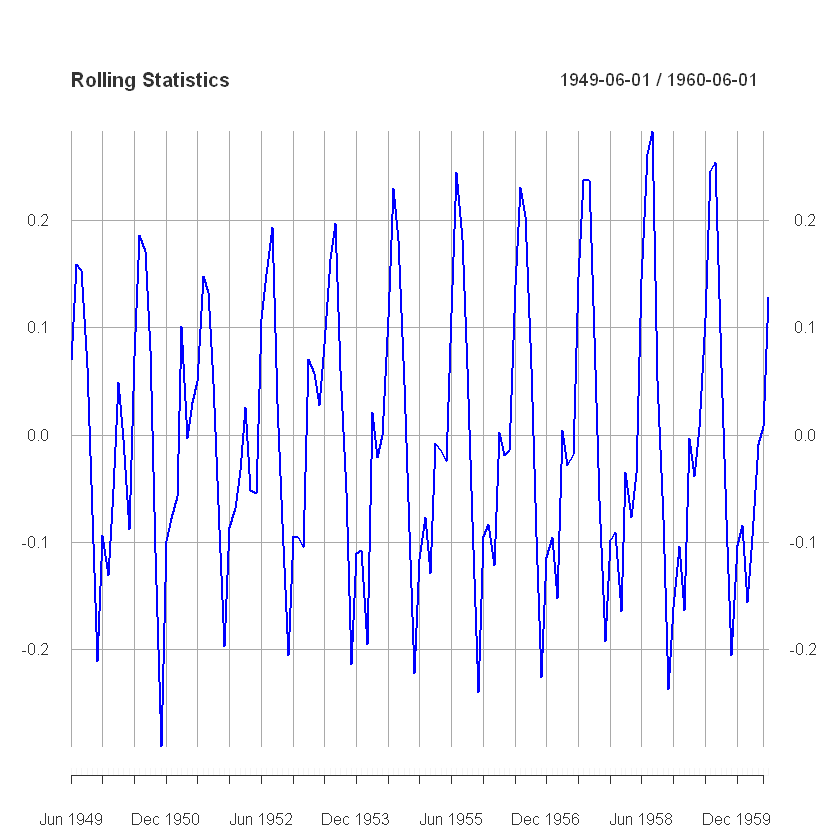

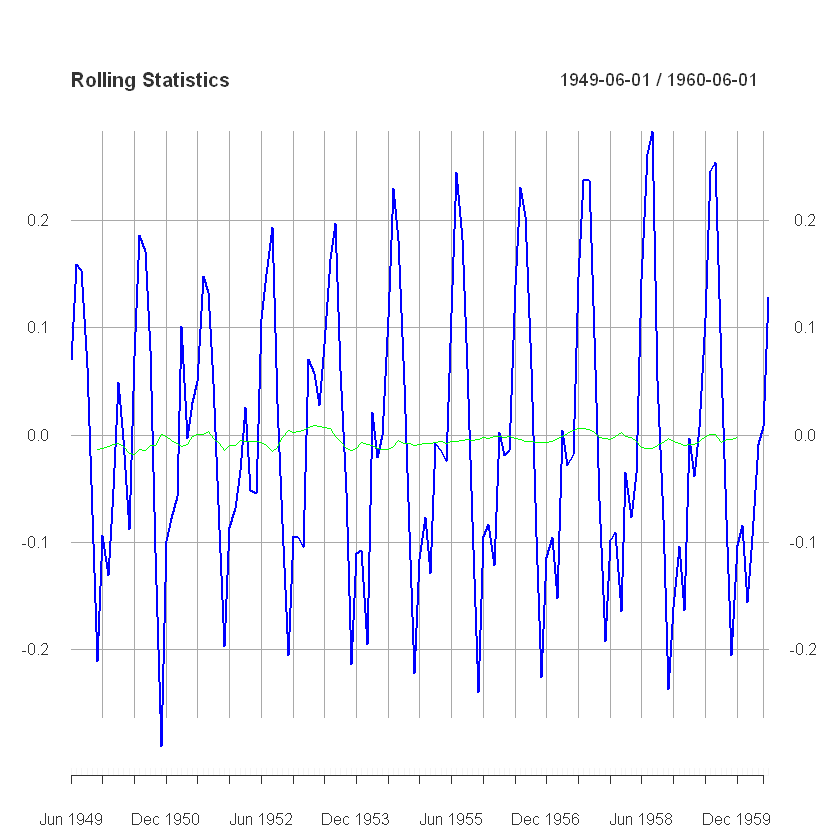

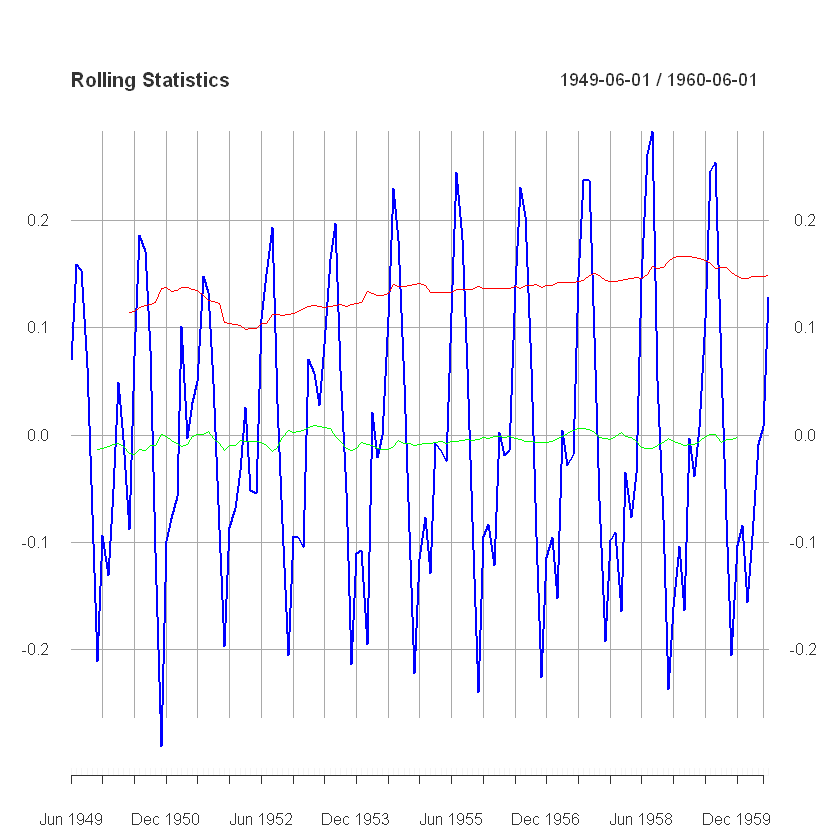

In [140]:
ts_log_moving_avg_diff<- na.omit(ts_log-moving_avg)

rolling_mean_test <- rollmean(ts_log_moving_avg_diff, k = 12,fill = NA)
rolling_sd_test <- rollapply(ts_log_moving_avg_diff, width = 12, FUN = sd,fill = NA)

plot(as.xts(ts_log_moving_avg_diff), type="l", col="blue", xlab = "time", ylab = "# passengers", main = "Rolling Statistics") 
lines(as.xts(rolling_mean_test), type="l", col="green") 
lines(as.xts(rolling_sd_test), type="l", col="red") 


In [141]:
adf.test(ts_log_moving_avg_diff, alternative = "stationary", k=12)
 #p-value <0.05, hence data is stationary


	Augmented Dickey-Fuller Test

data:  ts_log_moving_avg_diff
Dickey-Fuller = -4.02, Lag order = 12, p-value = 0.01045
alternative hypothesis: stationary


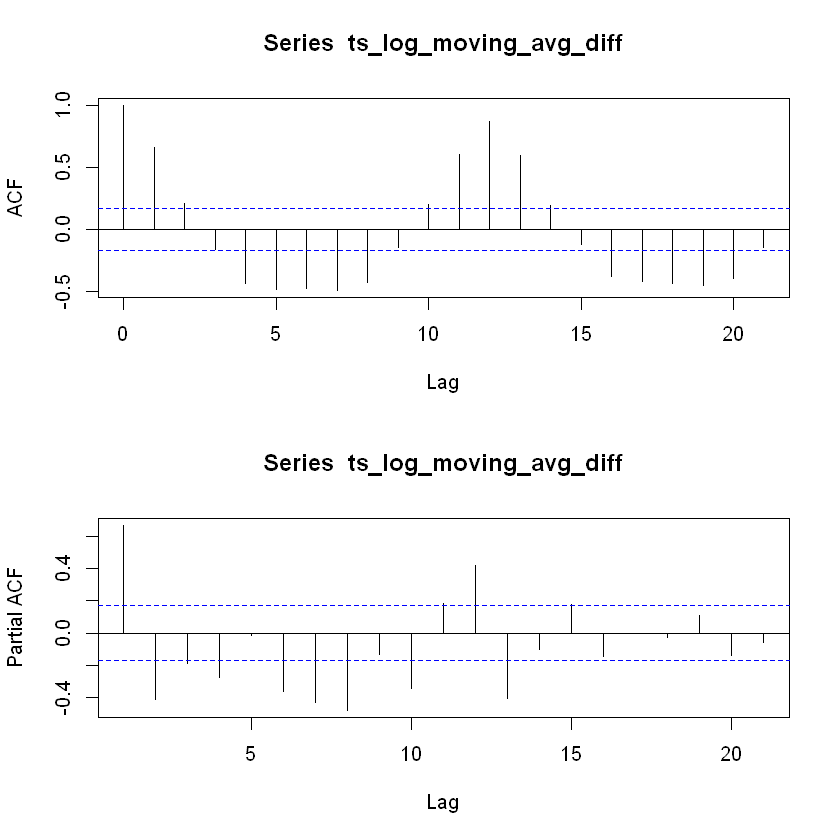

In [142]:
# ACF and PACF Plots
par(mfrow=c(2,1))
acf(ts_log_moving_avg_diff)
pacf(ts_log_moving_avg_diff)
par(mfrow=c(1,1))


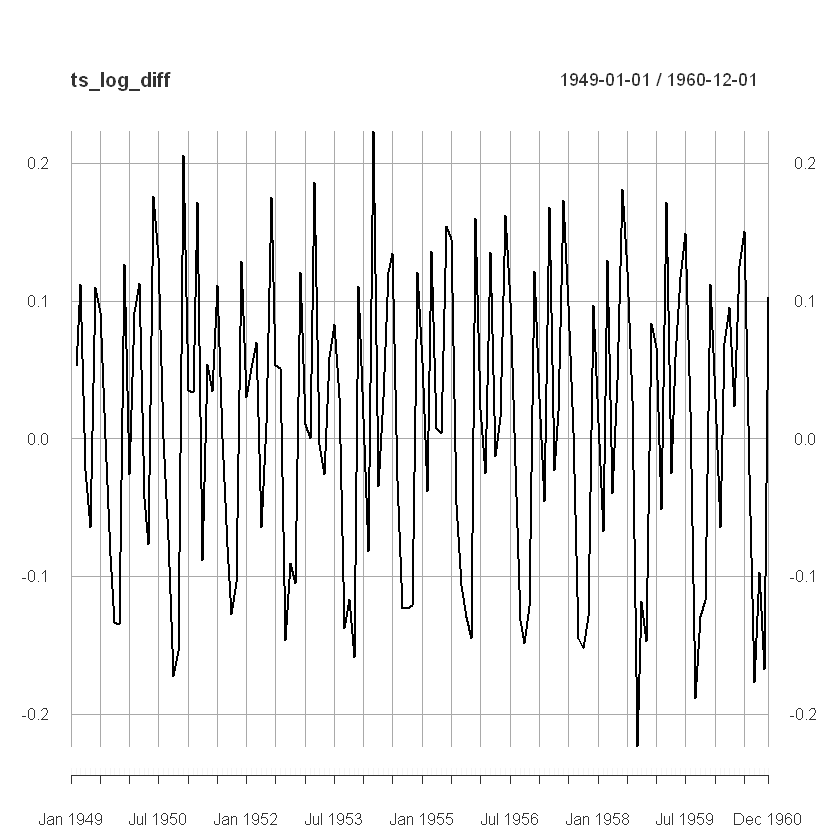

In [143]:
#Further Techniques to remove Seasonality and Trend
#The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.
#Differencing
#In this technique, we take the difference of the observation at a particular instant with that at the previous instant.
ts_log_diff <- diff(ts_log)

plot(ts_log_diff)


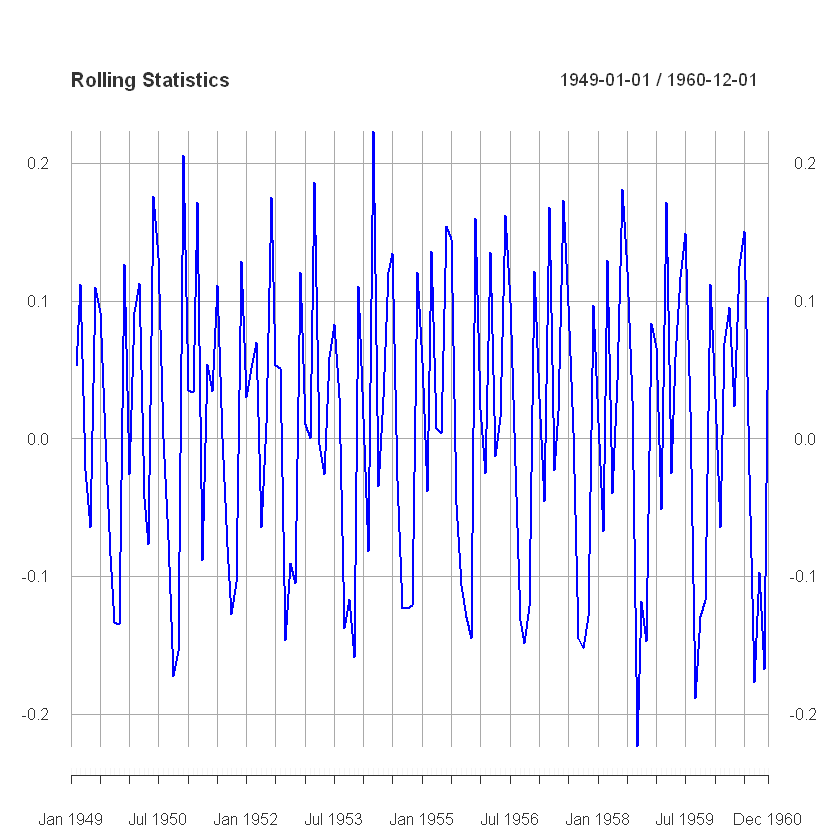

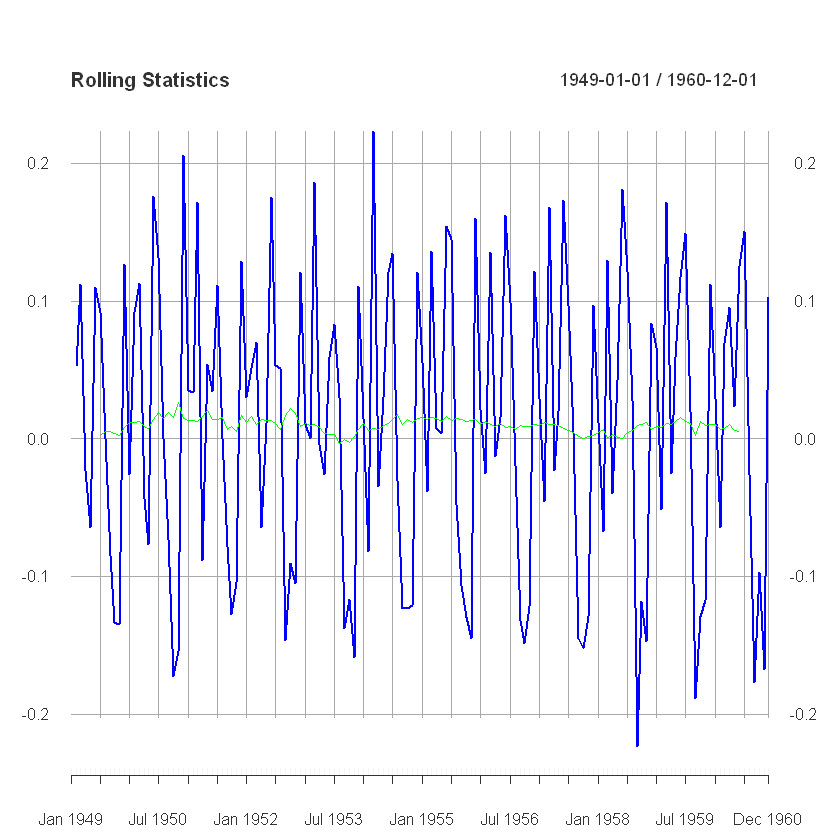

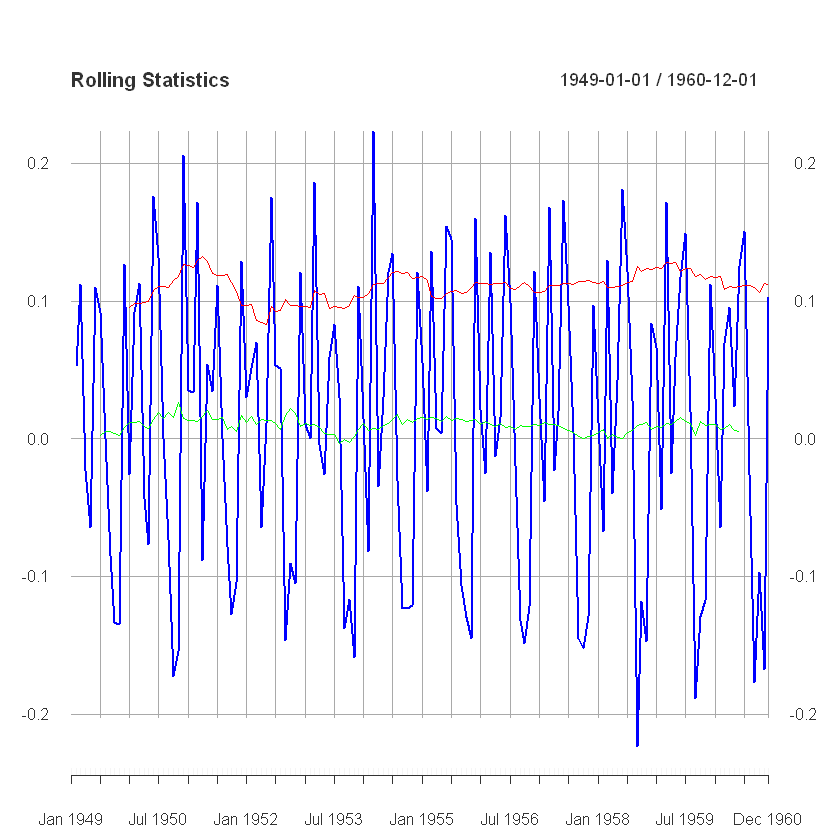

In [144]:
rolling_mean_test2 <- rollmean(ts_log_diff, k = 12, fill = NA)
rolling_sd_test2 <- rollapply(ts_log_diff, width = 12, FUN = sd, fill = NA)

plot(ts_log_diff, type="l", col="blue", xlab = "time", ylab = "# passengers", main = "Rolling Statistics") 
lines(rolling_mean_test2, type="l", col="green") 
lines(rolling_sd_test2, type="l", col="red") 


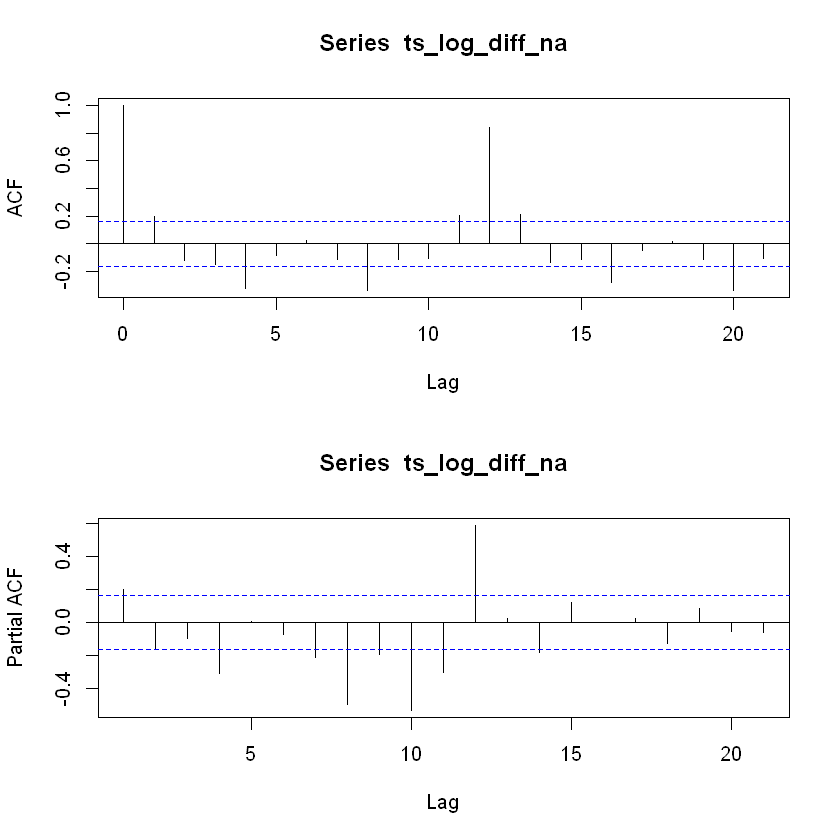

In [145]:
ts_log_diff_na <- na.omit(ts_log_diff)
par(mfrow=c(2,1))
acf(ts_log_diff_na)
pacf(ts_log_diff_na)
par(mfrow=c(1,1))

In [146]:
adf.test(ts_log_diff_na, alternative = "stationary", k=12) #p-value <0.05, hence data is stationary



	Augmented Dickey-Fuller Test

data:  ts_log_diff_na
Dickey-Fuller = -3.3656, Lag order = 12, p-value = 0.06313
alternative hypothesis: stationary


Autoregression (AR)
● The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
● Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates 
● past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


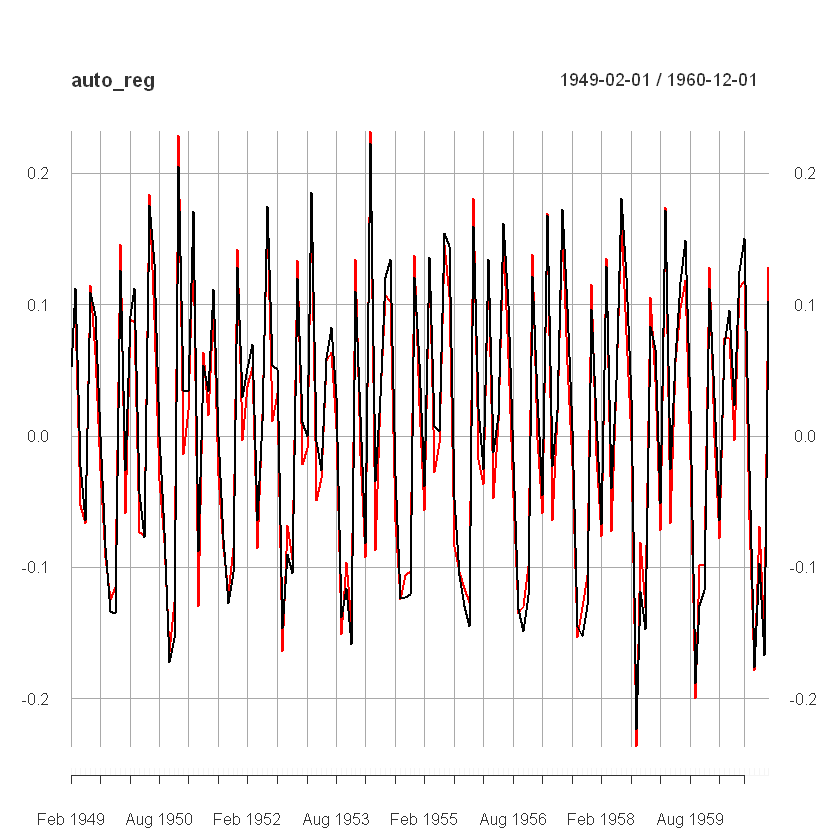

In [147]:
ar_fit <- ar.ols(ts_log_diff_na, order.max = 1, demean = F, intercept = T)
auto_reg <- cbind(ts_log_diff_na,ar_fit$resid)

par(mfrow=c(1,1))
plot(auto_reg)

In [148]:
#FUNCTION FOR ERROR CALCULATIONS

errorcalc <- function(z.chart, z.calc) {
  RMSE = round(rmse(z.chart, z.calc),3)
  MAPE = round(mape(z.chart, z.calc),3)
  MSE  = round(mse(z.chart, z.calc),3)
  RSE  = round(rse(z.chart, z.calc),3)
  MAE  = round(mae(z.chart, z.calc),3)
  SSE  = round(sse(z.chart, z.calc),3)
  
  cat("\n The Mean Squared Error is: ", MSE)
  cat("\n The Root Mean Squared Error is: ", RMSE)
  cat("\n The Mean Absolute Percentage Error is: ", MAPE)
  cat("\n The Mean Absolute Error is: ", MAE)
  cat("\n The Relative Squared Error is: ", RSE)
  cat("\n The Sum of Squared Error is: ", SSE)
  
}

In [149]:
auto_reg_na <- na.omit(auto_reg)

errorcalc(auto_reg_na$ts_log_diff_na,auto_reg_na$ar_fit.resid)


 The Mean Squared Error is:  0.001
 The Root Mean Squared Error is:  0.023
 The Mean Absolute Percentage Error is:  Inf
 The Mean Absolute Error is:  0.02
 The Relative Squared Error is:  0.048
 The Sum of Squared Error is:  0.077

In [150]:
#transforming zero to a small value (0.1 in this case) for MAPE calculation
auto_reg_na$ts_log_diff_na[auto_reg_na$ts_log_diff_na == 0] <- .1
errorcalc(auto_reg_na$ts_log_diff_na,auto_reg_na$ar_fit.resid)


 The Mean Squared Error is:  0.001
 The Root Mean Squared Error is:  0.031
 The Mean Absolute Percentage Error is:  0.587
 The Mean Absolute Error is:  0.022
 The Relative Squared Error is:  0.083
 The Sum of Squared Error is:  0.136

● RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

● From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

● On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations


### Moving Average (MA)

● Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. 

● For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [151]:
ma_fit <- ma(ts_log_diff_na, order = 3, centre = TRUE)


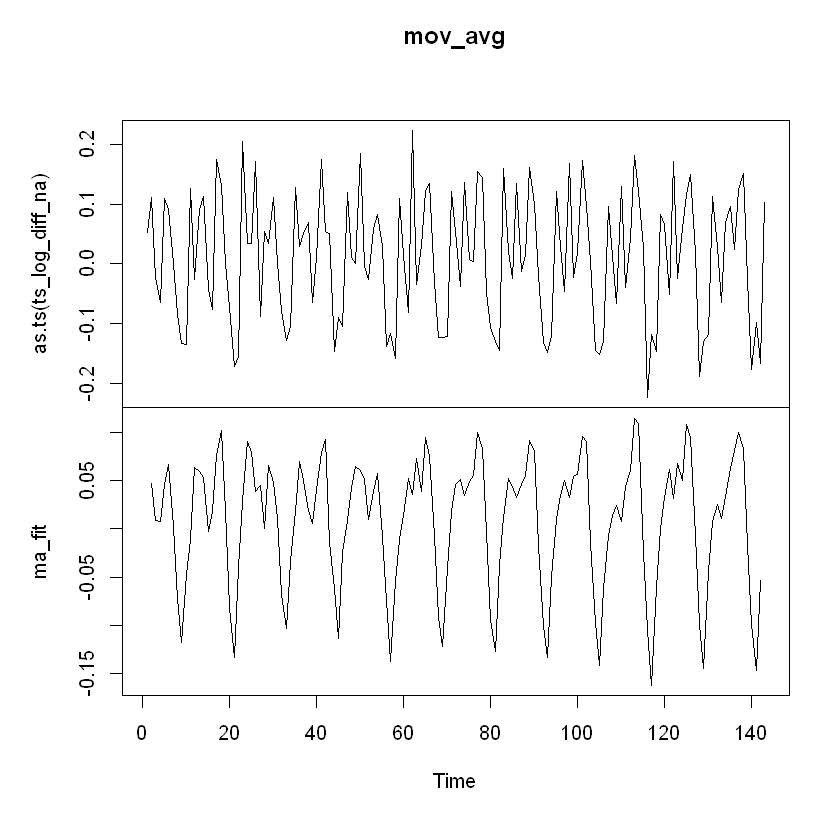

In [152]:
mov_avg <- cbind(as.ts(ts_log_diff_na),ma_fit)
plot(mov_avg)

Warning message:
"Removed 2 row(s) containing missing values (geom_path)."

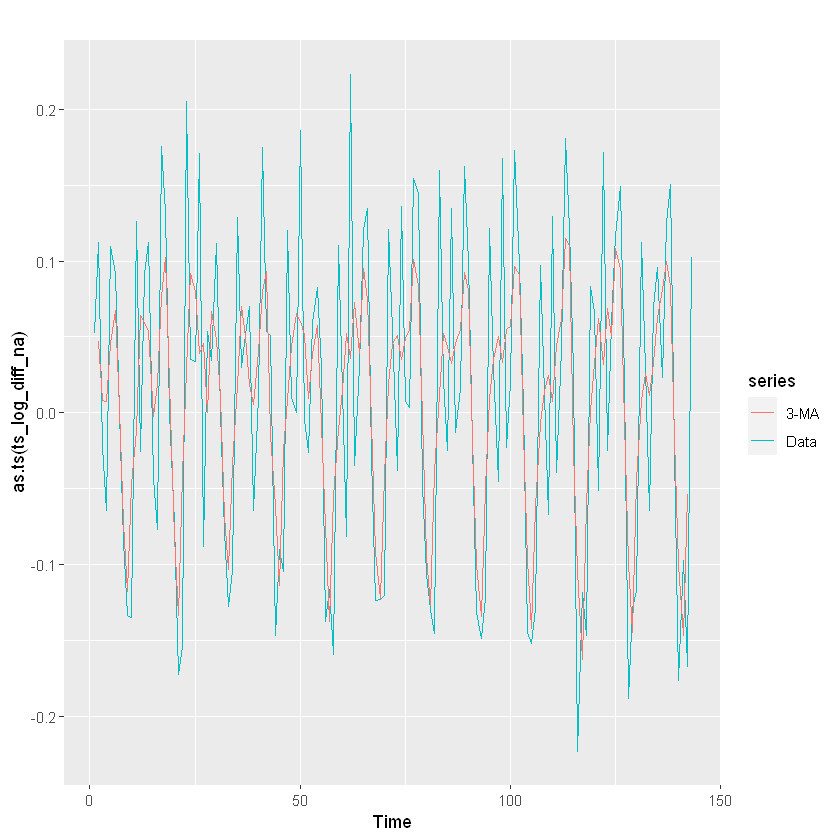

In [153]:
autoplot(as.ts(ts_log_diff_na), series = "Data") + 
  autolayer(ma(ts_log_diff_na, order = 3, centre = T), series = "3-MA")

In [154]:
mov_avg_na <- na.omit(mov_avg)
colnames(mov_avg_na) <- paste0("actual",1:2)

In [155]:
mov_avg_na <- as.data.frame(mov_avg_na)
errorcalc(mov_avg_na$actual1,mov_avg_na$actual2)


 The Mean Squared Error is:  0.005
 The Root Mean Squared Error is:  0.072
 The Mean Absolute Percentage Error is:  Inf
 The Mean Absolute Error is:  0.059
 The Relative Squared Error is:  0.456
 The Sum of Squared Error is:  0.73

In [156]:
#transforming zero to the series mean for MAPE calculation
mov_avg_na$actual1[mov_avg_na$actual1 == 0] <- .1
errorcalc(mov_avg_na$actual1,mov_avg_na$actual2)


 The Mean Squared Error is:  0.005
 The Root Mean Squared Error is:  0.073
 The Mean Absolute Percentage Error is:  1.101
 The Mean Absolute Error is:  0.06
 The Relative Squared Error is:  0.459
 The Sum of Squared Error is:  0.75

###  Autoregressive Integrated Moving Average (ARIMA)
    
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: 

● seasonality, 

● trend, and 

● noise. 

These parameters are labeled p,d,and q.

● Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

● Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

● Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


### Observations from EDA on the time series:

● Non stationarity implies at least one level of differencing (d) is required in ARIMA

● The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots

###  Interpreting ACF plots

● Exponential, decaying to zero - Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model	

● Alternating positive and negative, decaying to zero - Autoregressive model.	Use the partial autocorrelation plot to help identify the order.	

● One or more spikes, rest are essentially zero - Moving average model, order identified by where plot becomes zero.	

● Decay, starting after a few lags - Mixed autoregressive and moving average (ARMA) model.	

● All zero or close to zero - Data are essentially random.	

● High values at fixed intervals - Include seasonal autoregressive term.	

● No decay to zero - Series is not stationary

### Note: 
    A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.


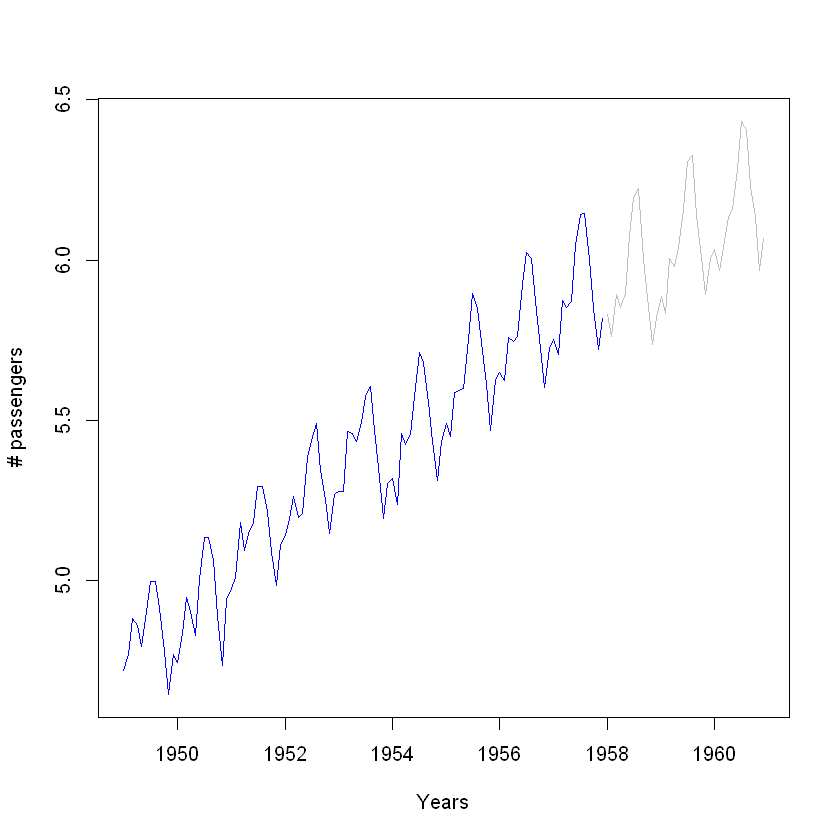

In [157]:
#dividing into train and test data sets

train_ts <- ts_log[1:108,]
test_ts <- ts_log[109:144,]

plot.zoo(cbind(train_ts, test_ts), 
         plot.type = "single", 
         col = c("Blue", "gray"), ylab = "# passengers", xlab = "Years")

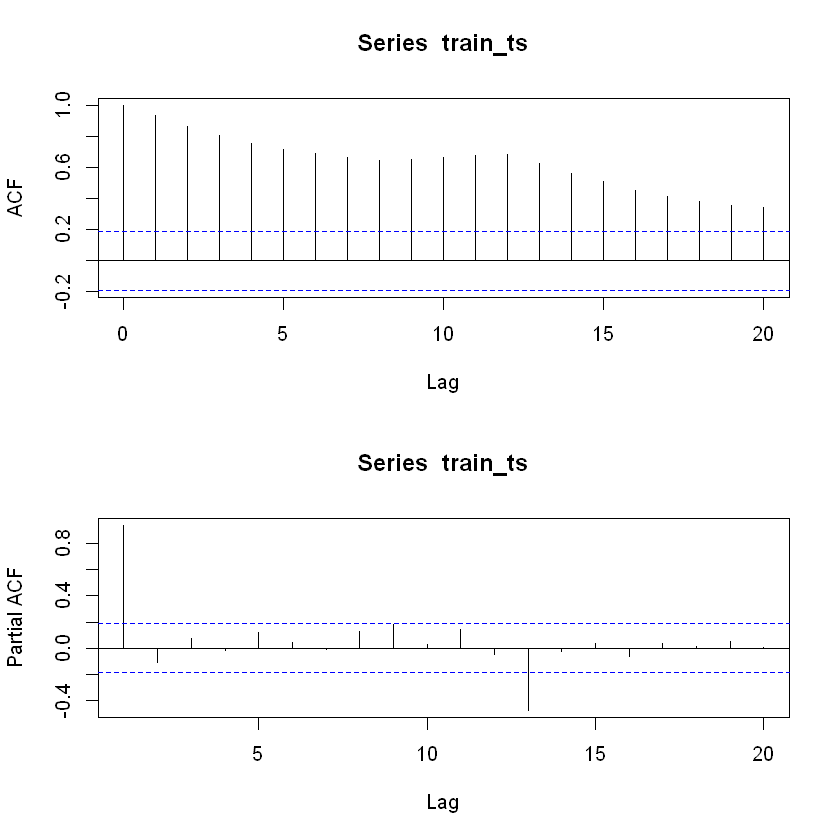

In [158]:
# ACF and PACF Plots
par(mfrow=c(2,1))
acf(train_ts)
pacf(train_ts)
par(mfrow=c(1,1))


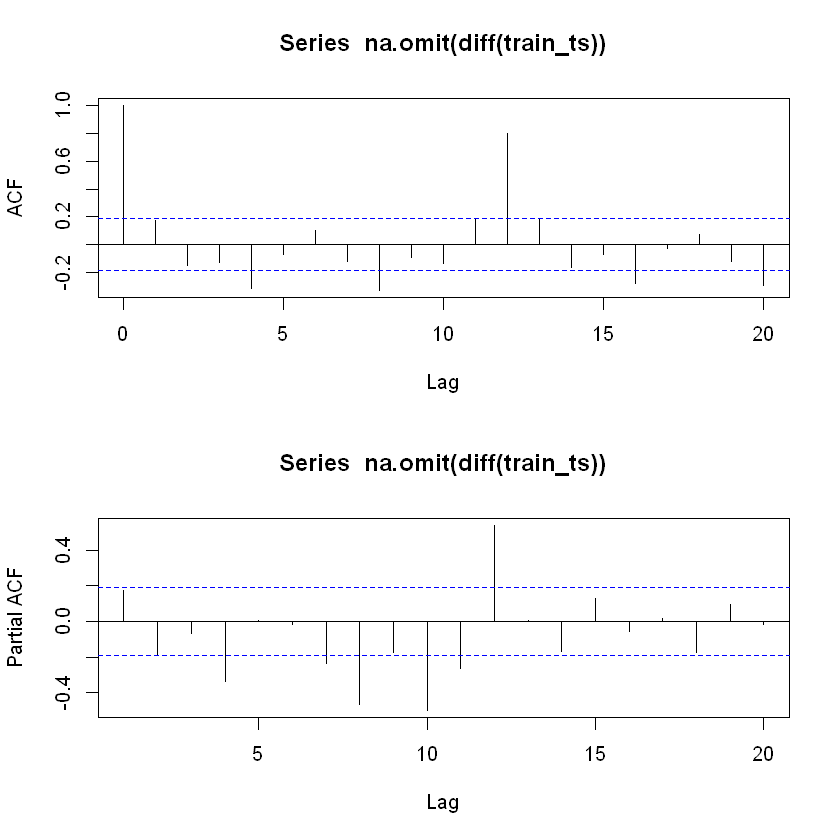

In [159]:

#since the ACF graph is not exponentially decreasing, meaning non stationary data, we will try after differencing once
par(mfrow=c(2,1))
acf(na.omit(diff(train_ts)))
pacf(na.omit(diff(train_ts)))
par(mfrow=c(1,1))

From these graphs, it is clear that a first order differencing is required for ARIMA modeling, meaning d=1

Clearly, An AR(2) has a sinusoidal ACF that converges to 0. Therefore p should be 2.

While value of q should be 1 or 2. 

After a few iterations, we found that (2,1,1) as (p,d,q) comes out to be the combination with least AIC and BIC.

In [160]:
fit_arima <- arima(train_ts, c(2, 1, 1),seasonal = list(order = c(2, 1, 1)))

In [161]:
#The output from fitarima() includes the fitted coefficients and the standard error (s.e.) for each coefficient
library(lmtest)
coeftest(fit_arima)

Warning message in sqrt(diag(se)):
"NaNs produced"


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1   0.477051         NA      NA        NA    
ar2  -0.096282         NA      NA        NA    
ma1  -1.000000   0.044686 -22.378 < 2.2e-16 ***
sar1  0.477051         NA      NA        NA    
sar2 -0.096282         NA      NA        NA    
sma1 -1.000000   0.044686 -22.378 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [162]:

#Observing the coefficients we can exclude the insignificant ones. We can use a function confint() for this purpose.
confint(fit_arima)

Warning message in sqrt(diag(vcov(object))):
"NaNs produced"

,2.5 %,97.5 %
ar1,NaN,NaN
ar2,NaN,NaN
ma1,-1.087583,-0.912417
sar1,NaN,NaN
sar2,NaN,NaN
sma1,-1.087583,-0.912417


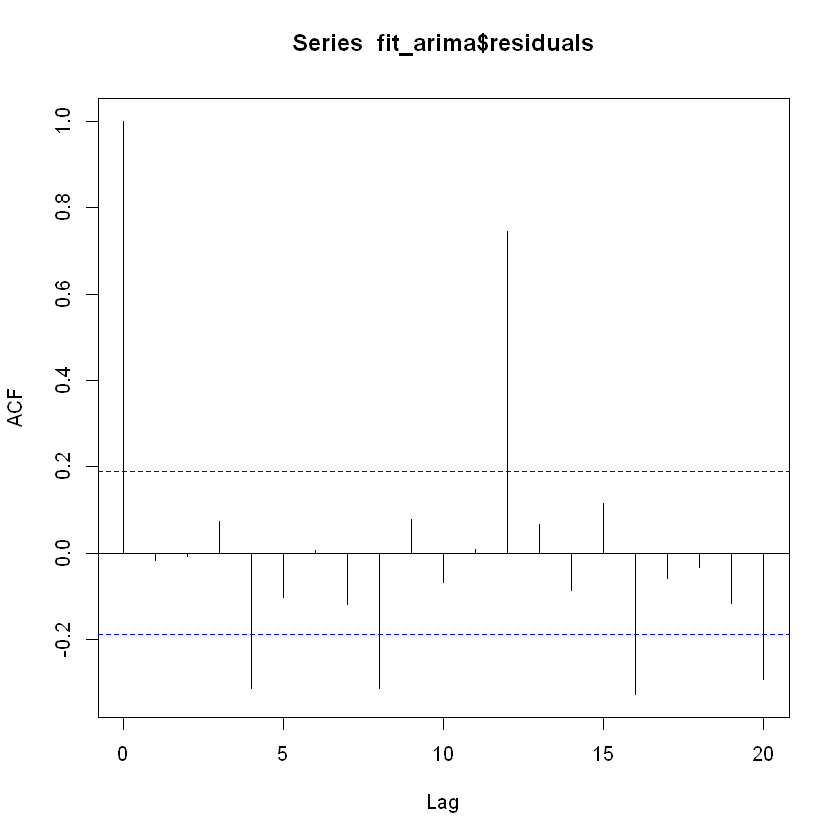

In [163]:

acf(fit_arima$residuals) #The ACF of the residuals shows no significant autocorrelations.

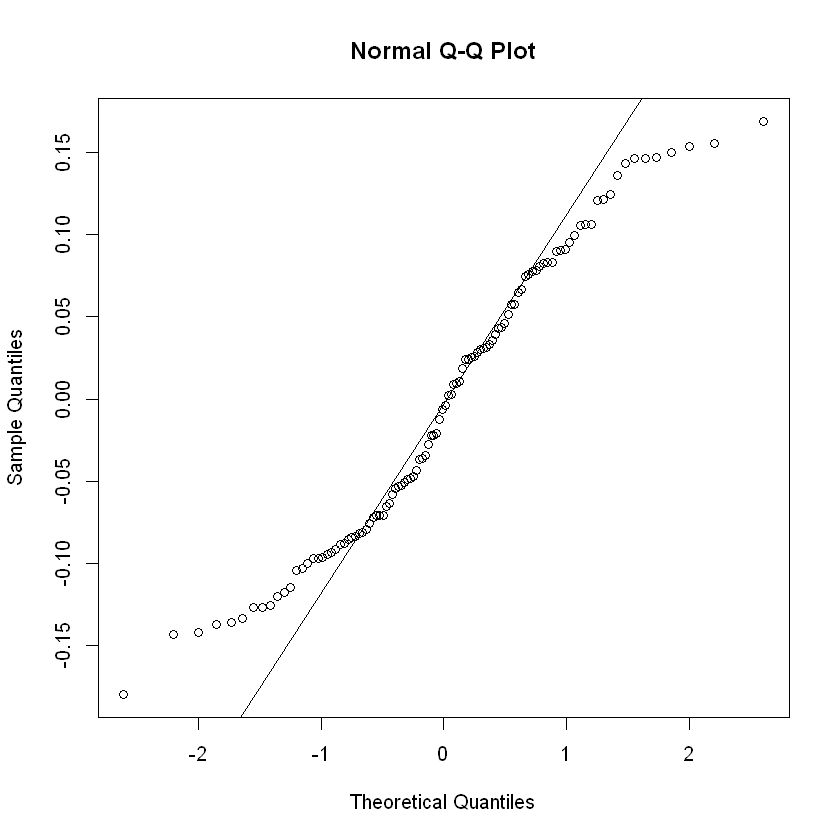

In [164]:
library(FitAR)

boxresult <- Box.test(resid(fit_arima),type="Ljung",lag=2) #The p-values for the Ljung-Box Q test all are well above 0.05, indicating “non-significance.”
qqnorm(fit_arima$residuals)
qqline(fit_arima$residuals) #The values are normal as they rest on a line and aren’t all over the place


As all the graphs are in support of the assumption that there is no pattern in the residuals, we can go ahead and calculate the forecast.


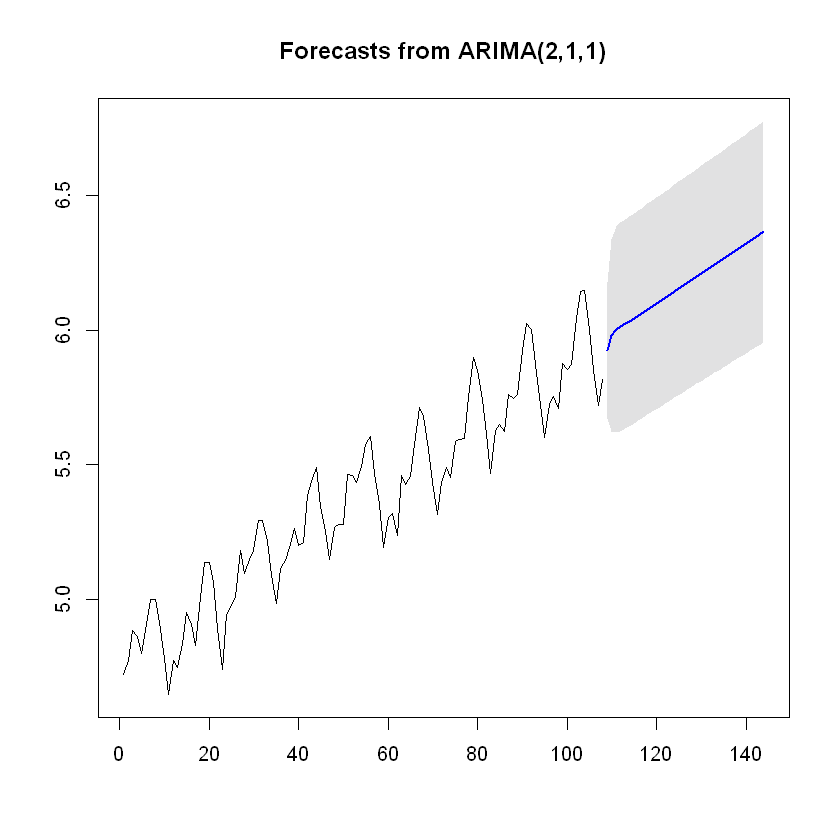

In [165]:
futurVal <- forecast(fit_arima,h=36, level=c(99.5))

plot(futurVal)

Converting the log transform to normal

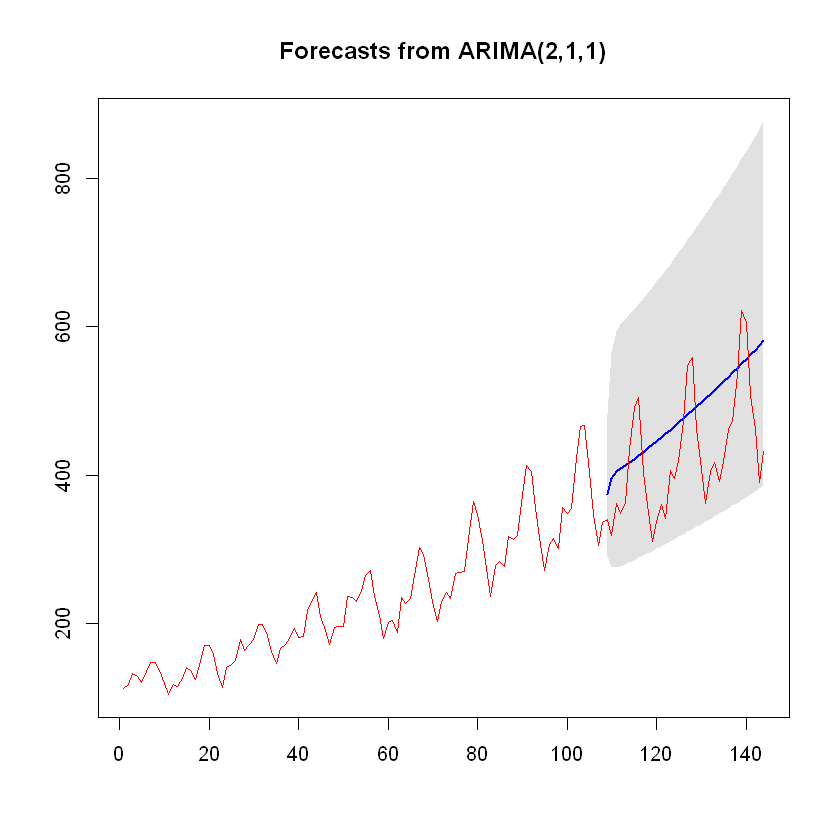

In [166]:
futurVal$mean<-exp(futurVal$mean)
futurVal$upper<-exp(futurVal$upper)
futurVal$lower<-exp(futurVal$lower)
futurVal$x<-exp(futurVal$x)
plot(futurVal)
lines(IntlAirPassengers$monthly_passengers, col="red")


In [167]:
#Error Calc
test_ts2 <- as.data.frame(test_ts)
futurevalue <- as.data.frame(na.omit(futurVal$mean))
errorcalc2 <- cbind(test_ts2,futurevalue)
head(errorcalc2)


,V1,x
1958-01-01,5.828946,374.0766
1958-02-01,5.762051,395.4487
1958-03-01,5.891644,404.3442
1958-04-01,5.852202,408.8551
1958-05-01,5.894403,412.7976
1958-06-01,6.075346,417.0599


In [168]:

errorcalc(errorcalc2$V1,errorcalc2$x)


 The Mean Squared Error is:  229219.6
 The Root Mean Squared Error is:  478.769
 The Mean Absolute Percentage Error is:  78.577
 The Mean Absolute Error is:  475.44
 The Relative Squared Error is:  7348094
 The Sum of Squared Error is:  8251905

In [169]:
#To verify, we tested the same to see the model with best fit through the auto arima function, and it gave the same results
fit_auto_arima <- auto.arima(train_ts, d=1, seasonal = TRUE, max.p = 3, max.q = 3, trace=TRUE)




 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -176.7319
 ARIMA(1,1,0) with drift         : -177.8195
 ARIMA(0,1,1) with drift         : -179.419
 ARIMA(0,1,0)                    : -177.77
 ARIMA(1,1,1) with drift         : -182.0914
 ARIMA(2,1,1) with drift         : Inf
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,2) with drift         : Inf
 ARIMA(2,1,0) with drift         : -179.679
 ARIMA(1,1,1)                    : -183.3575
 ARIMA(0,1,1)                    : -180.8064
 ARIMA(1,1,0)                    : -179.168
 ARIMA(2,1,1)                    : -187.7857
 ARIMA(2,1,0)                    : -180.7544
 ARIMA(3,1,1)                    : -185.8498
 ARIMA(2,1,2)                    : -185.8261
 ARIMA(1,1,2)                    : -187.376
 ARIMA(3,1,0)                    : -178.9851
 ARIMA(3,1,2)                    : -186.5777

 Best model: ARIMA(2,1,1)                    



### <red> References:
https://github.com/
    
https://medium.com/

https://towardsdatascience.com/

http://r-statistics.co/Time-Series-Analysis-With-R.html

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

https://cran.r-project.org/view=TimeSeries

https://www.tutorialspoint.com/r/r_time_series_analysis.htm
